<a href="https://colab.research.google.com/github/minjaee98/Capstone-/blob/main/%EC%BA%A1%EB%94%94_%EC%B5%9C%EC%A2%85%EB%B0%9C%ED%91%9C1%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
from fastai.vision.all import *
import pandas as pd
import glob
import matplotlib.pyplot as plt

# 데이터 경로 설정
path_No = "/content/drive/MyDrive/학술제/data/no1/*"
path_Yes = "/content/drive/MyDrive/학술제/data/yes1/*"

# 이미지 경로와 라벨 생성
image_paths = []
labels = []

# 종양이 있는 이미지 경로 추가
for file in glob.glob(path_Yes):
    image_paths.append(file)
    labels.append(1)  # 1: 종양 있음

# 종양이 없는 이미지 경로 추가
for file in glob.glob(path_No):
    image_paths.append(file)
    labels.append(0)  # 0: 종양 없음

# 이미지 경로와 라벨을 데이터프레임으로 변환
df = pd.DataFrame({'image': image_paths, 'label': labels})

# DataBlock 생성 및 train-validation split 설정
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('image'),
                   get_y=ColReader('label'),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Validation Set 설정 (20%)
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())  # 데이터 증강 추가 가능

# DataLoader 생성
dls = dblock.dataloaders(df, bs=32)

# 모델 학습 (ResNet50)
learn = cnn_learner(dls, resnet50, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


In [ ]:
# 모델 학습 (10 에폭 설정)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.784850,1.391620,0.570175,04:17


epoch,train_loss,valid_loss,accuracy,time
0,0.463189,0.835324,0.710526,05:38
1,0.433459,0.439157,0.842105,05:30
2,0.390039,0.342624,0.912281,05:33
3,0.335426,0.469061,0.868421,05:30
4,0.270945,0.351244,0.912281,06:16
5,0.220519,0.355077,0.921053,05:42
6,0.207348,0.316966,0.921053,05:30
7,0.179967,0.338393,0.921053,05:28
8,0.144600,0.316288,0.929825,05:28
9,0.129080,0.321040,0.929825,05:29


In [ ]:
# 학습 기록 출력
print(learn.recorder.values)

[[0.4631894528865814, 0.835323691368103, 0.7105262875556946], [0.4334593713283539, 0.4391568601131439, 0.8421052694320679], [0.3900390863418579, 0.3426239490509033, 0.9122806787490845], [0.33542564511299133, 0.4690609872341156, 0.8684210777282715], [0.2709450125694275, 0.3512437641620636, 0.9122806787490845], [0.22051894664764404, 0.3550768494606018, 0.9210526347160339], [0.20734772086143494, 0.3169657289981842, 0.9210526347160339], [0.17996744811534882, 0.3383934497833252, 0.9210526347160339], [0.14460045099258423, 0.3162878155708313, 0.9298245906829834], [0.12908028066158295, 0.32103973627090454, 0.9298245906829834]]


In [ ]:
# 학습 결과 시각화
# Training Loss는 learn.recorder.losses에서 바로 가져올 수 있음
train_losses = [loss.item() for loss in learn.recorder.losses]

# Validation Loss와 Accuracy는 learn.recorder.values를 통해서 가져옴
val_losses = []
val_accuracies = []

for v in learn.recorder.values:
    if len(v) > 1:  # Validation Loss와 Accuracy가 있는지 확인
        val_losses.append(v[1])  # Validation Loss는 인덱스 1
        if len(v) > 2:
            val_accuracies.append(v[2])  # Validation Accuracy는 인덱스 2

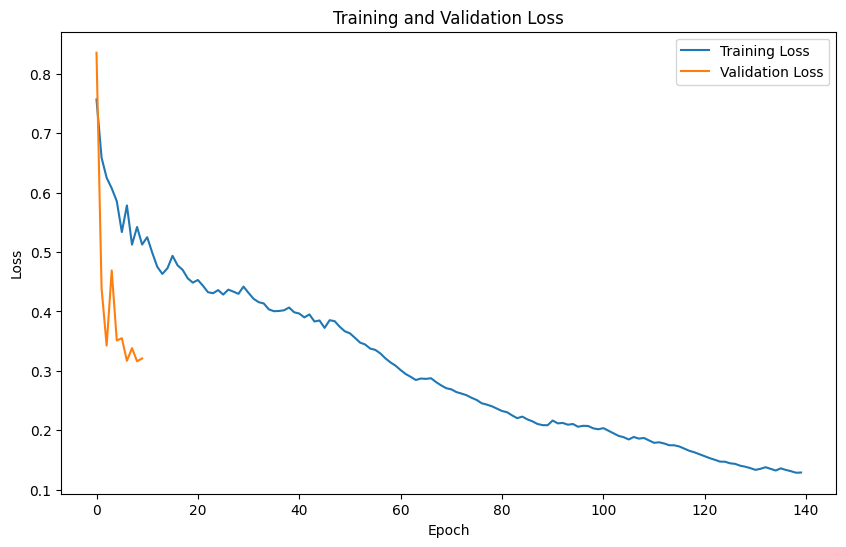

In [ ]:
# Training and Validation Loss 시각화
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

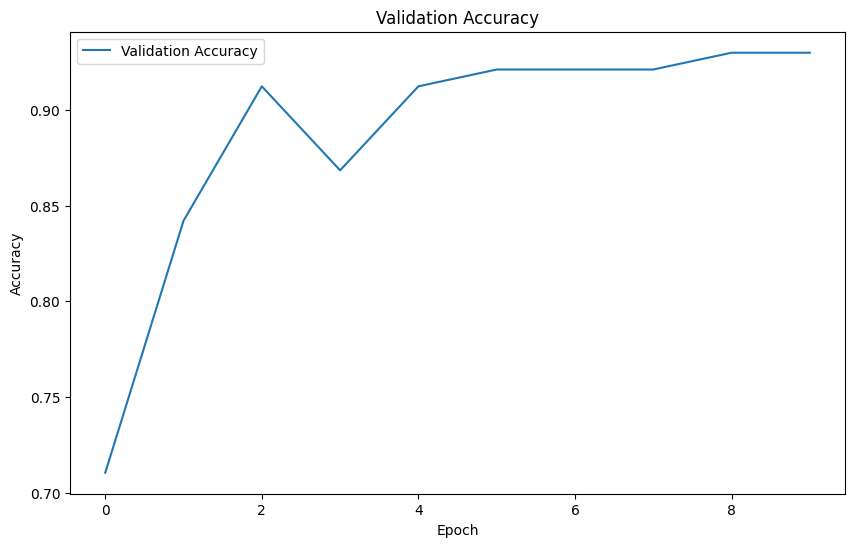

In [ ]:
# Validation Accuracy 시각화
if val_accuracies:
    plt.figure(figsize=(10,6))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("No validation accuracies found to plot.")

In [ ]:
# 모델 평가 (테스트 데이터로 평가)
# Test DataLoader를 생성 (테스트 데이터는 따로 나누어서 준비)
test_dl = learn.dls.test_dl(df)

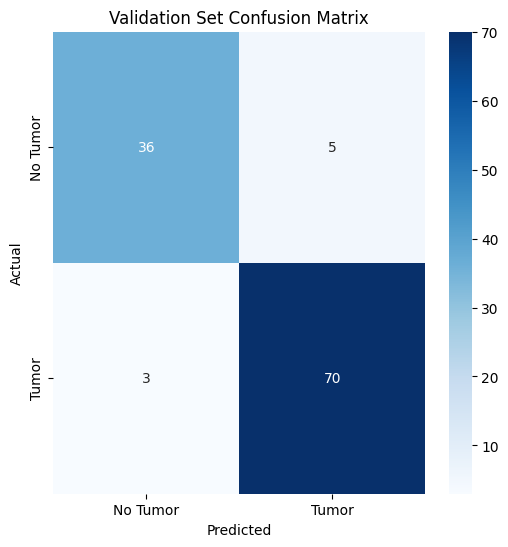

Classification Report:
               precision    recall  f1-score   support

    No Tumor       0.92      0.88      0.90        41
       Tumor       0.93      0.96      0.95        73

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



In [ ]:
# 필요한 라이브러리 임포트
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Validation Set에서 예측 수행
preds_val, actual_val_labels = learn.get_preds(dl=dls.valid)

# 예측된 라벨
pred_val_labels = preds_val.argmax(dim=1)

# 실제 라벨은 get_preds에서 가져온 라벨을 사용 (텐서형태)
actual_val_labels = actual_val_labels.long()

# 혼동 행렬 생성 및 시각화 (Validation Set)
cm_val = confusion_matrix(actual_val_labels, pred_val_labels)

plt.figure(figsize=(6,6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Set Confusion Matrix')
plt.show()

# 성능 요약 출력
print("Classification Report:\n", classification_report(actual_val_labels, pred_val_labels, target_names=['No Tumor', 'Tumor']))


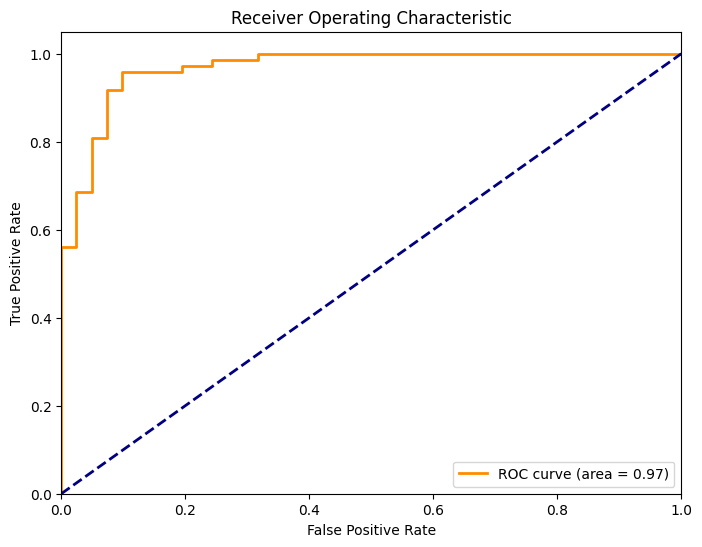

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 그리기
pred_probs = preds_val[:, 1].detach().numpy()  # 종양에 대한 예측 확률
fpr, tpr, _ = roc_curve(actual_val_labels, pred_probs)  # 실제 라벨과 예측 확률 사용
roc_auc = auc(fpr, tpr)  # AUC 계산

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


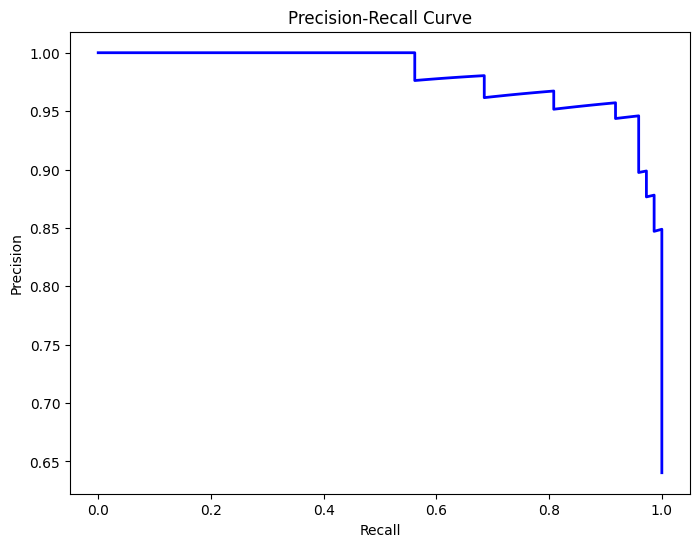

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(actual_val_labels, pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


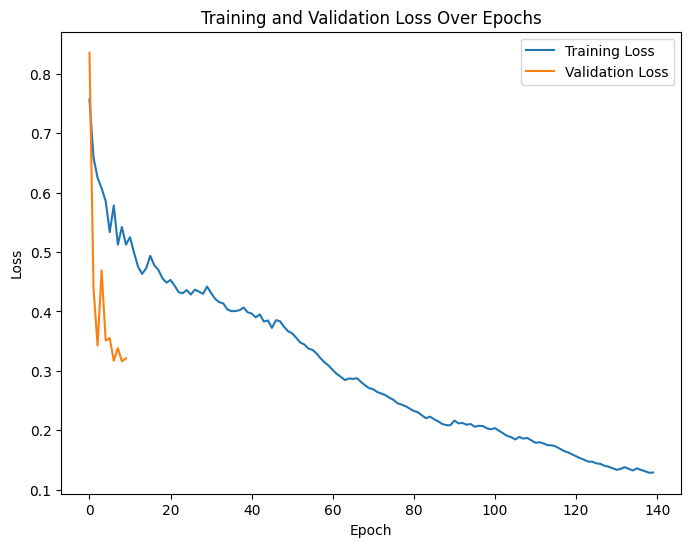

In [ ]:
# Training 및 Validation Loss 시각화
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


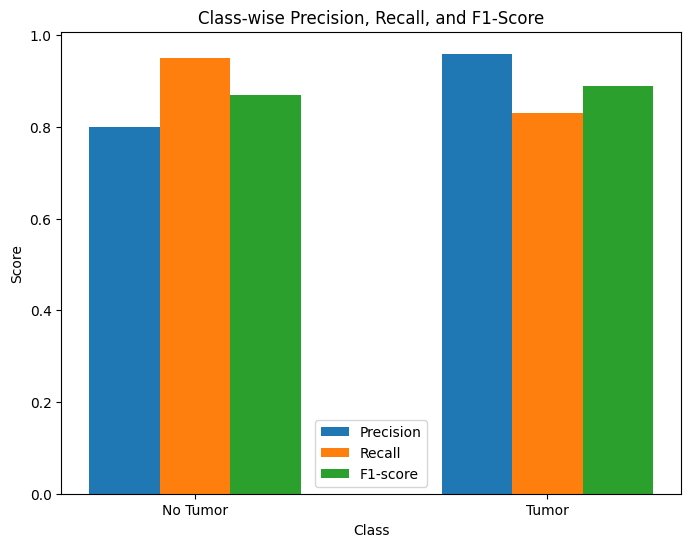

In [ ]:
import numpy as np

# 성능 지표 데이터
labels = ['No Tumor', 'Tumor']
precision = [0.80, 0.96]  # 성능 요약표에서 가져온 Precision 값
recall = [0.95, 0.83]     # 성능 요약표에서 가져온 Recall 값
f1_scores = [0.87, 0.89]  # 성능 요약표에서 가져온 F1-Score 값

x = np.arange(len(labels))  # 클래스 수에 따른 x축 값
width = 0.2  # 막대 너비 설정

plt.figure(figsize=(8, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_scores, width, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Class-wise Precision, Recall, and F1-Score')
plt.xticks(x, labels)
plt.legend()
plt.show()
